<a href="https://colab.research.google.com/github/TimilsinaSushil/Thesis/blob/DNN/Random_Forest_Hyperparameter_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install torch==1.3.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install inltk
!pip install bayesian-optimization



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.8 MB/s 
     |████████████████████████████████| 1.1 MB 48.6 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 233 kB 65.1 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 271 kB 41.7 MB/s 
     |████████████████████████████████| 144 kB 43.4 MB/s 
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26325 sha256=467eff09af7ce239953b2711f7d0551dffc3d36b7e8a3f5b5520d3841d4b240e
  Stored in directory: /root/.cache/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully built typing
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=c51b7df2467906eeabe2385b3f56f930a2c3556903a989e24c7eb2808345c9d1
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [107]:
from inltk.inltk import setup
from inltk.inltk import tokenize
from inltk.inltk import get_embedding_vectors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import asyncio
asyncio.set_event_loop(asyncio.new_event_loop())
setup('ne')


RuntimeError: ignored

Done!


In [108]:
! gdown --id 116JOC660mWu8DdiLwS8-CLDZdfDPDoeG
df = pd.read_csv('QSN.csv')


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=116JOC660mWu8DdiLwS8-CLDZdfDPDoeG
To: /content/QSN.csv
100% 1.05M/1.05M [00:00<00:00, 127MB/s]


['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']


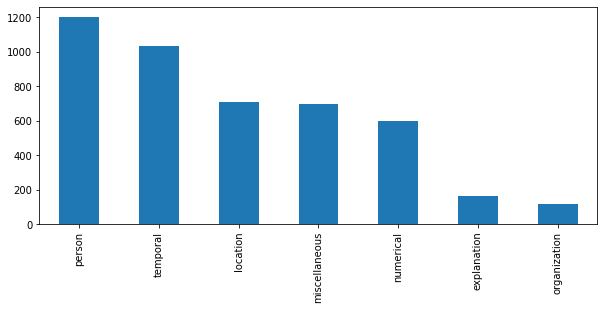

In [109]:
#coarse type filtering
df=df[df['CoarseType'].isin(['location','temporal','numerical','person','organization','explanation','miscellaneous'])]
coarse_type=df['CoarseType'].unique()
print(coarse_type)
plt.figure(figsize=(10,4))
df.CoarseType.value_counts().plot(kind='bar');


**Text Preprocessig**

In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
#removing text inside brackets and quotes
import re
def removeTextInsideQuotesAndBrackets(text):
  text=re.sub("[\(\[].*?[\)\]]", "", text)
  text=re.sub("\'.*?\'","",text)
  text=re.sub('\".*?\"',"",text)
  return text

In [7]:
def removeKo(text):
  words= text.split()
  text=[]
  for word in words:
    length=len(word)
    if(length > 2):
      if(word[-2]=='क' and word[-1]=='ो'):
        if(word!='कसको'):
          word= word[:length-2]
    text.append(word)
  text=' '.join([word for word in text])
  # print(text)
  return text




In [8]:
def preprocessing(questions):
  questions=questions.apply(removeTextInsideQuotesAndBrackets)
  questions = questions.apply(removeKo)
  #tokenization
  questions= questions.apply(lambda x: tokenize(x,'ne'))
  #removing duplicates
  questions= questions.apply(lambda x: list(dict.fromkeys(x)))
  
  questions=questions.apply(lambda x: ' '.join(x).replace('▁','').split())
  questions=questions.apply(lambda x: ' '.join(x))

  #removing numbers
  questios=questions.apply(lambda x: ''.join(c for c in x if not c.isdigit()))
  #removing punctuation
  punctuation=['!','"','#','$','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',"]",'^','_','`','{','|','}','~']
  questions = questions.apply(lambda x: ''.join(c for c in x if c not in punctuation))

  #removing stopwords
  WHWORDS = ['कुन','कहिले','के','कति','को','कसले','कहाँ','कसलाई','कसको','कस्तो','कति','कसरी','किन','कता']
  STOPWORDS = stopwords.words('nepali')
  # Removig WH words from STOPWORDS
  for word in WHWORDS:
    if word in STOPWORDS: STOPWORDS.remove(word)

  STOPWORDS=set(STOPWORDS)
  def clean_text(text):
      text=' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
      return text
  questions = questions.apply(clean_text)
  return questions



In [13]:
df['Questions'] = preprocessing(df['Questions'])

dataset=df

df.head()

,Questions,Answer,CoarseType,FineType,WhWord,Domain
0,नेपाली क्रिकेट टिम क्याप्टेन ज्ञानेन्द्र मल्ल ...,वि.सं. २०७६ कार्तिक १३,temporal,date,कहिले,Sports
1,फ्रान्स लियोन सम्पन्न महिला विश्वकप फुटबल २०१९...,अमेरिका,location,country,कसले,Sports
2,विश्व शान्ति सू चा ंक २०१९ नेपाल कति औ स्थानमा...,७६ औ स्थानमा,numerical,rank,कति,Miscellaneous
3,फलफूल बोट रु दश नोट कार्यक्रम सुरुवात कुन जिल्...,"इच्छाकामना गाउँपालिका, चितवन",location,city,कुन,Politics
4,माथिल्लो त्रिशुली थ्री जल विध ुत आयोजना विधुत ...,वि.स. २०७६ जेठ ०२,temporal,date,कहिले,Miscellaneous


In [14]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Questions'])
vocab_size=len(tokenizer.word_index)
sequences = tokenizer.texts_to_sequences(df['Questions'])
from keras.preprocessing.sequence import pad_sequences
maxlen = max([len(i) for i in sequences])
padded_sequences = pad_sequences(sequences, maxlen)

**One hot encoding of labels**

In [54]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
le = preprocessing.LabelEncoder()
y=df.CoarseType
# print(y.unique())
y = le.fit_transform(y)
# y = to_categorical(y) 

**Coarse Grained Classification**

In [139]:
def coarseGrained(k_fold,test_size,n_estimators):
  from sklearn.model_selection import train_test_split
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import fbeta_score
  from sklearn.metrics import classification_report
  from sklearn.ensemble import RandomForestClassifier
  
  x=padded_sequences
  test_size=0.2
  k_fold=5
  # max_depth=2
  n_estimators=100

  x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=test_size) 
  metrics = []
  skf= StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)


  #Create a Gaussian Classifier
  model=RandomForestClassifier(n_estimators=n_estimators)

   # K fold cross validation
  for train_index, validation_index in skf.split(x_train, y_train):
      # print("TRAIN:", train_index, "VALIDATION:", validation_index)
      X_train, X_validation = x_train[train_index], x_train[validation_index]
      Y_train, Y_validation = y_train[train_index], y_train[validation_index]
     
  #   # train the model
      model.fit(X_train,Y_train)
  #   # validate the model 
      Y_pred_class_for_validation = model.predict(X_validation)
      metrics.append(accuracy_score(Y_validation, Y_pred_class_for_validation))
      # print(classification_report(y_test, y_pred_class,target_names=coarse_type))

  # metrics = np.array(metrics)
  # print('Validation Accuracy for each Iteration',metrics)
  # print('Mean accuracy for validation set: ', np.mean(metrics, axis=0))
  # print('Std for accuracy: ', np.std(metrics, axis=0))
  # print('---------------------------------------------------------------------------------')

 

  y_pred=model.predict(x_test)
  test_accuracy=accuracy_score(y_test, y_pred)

  # print("Test Accuracy:",test_accuracy)
  return test_accuracy



In [144]:
from bayes_opt import BayesianOptimization
pbounds = {
    'k_fold': (5, 10), 
    'test_size':(20,50),
    # 'max_depth':(100,1000),
    'n_estimators':(100,1000),
    }
optimizer = BayesianOptimization(
    f=coarseGrained,
    pbounds=pbounds,
    verbose=2, 
    random_state=42,
)

n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.

init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.

In [145]:
optimizer.maximize(init_points = 1, n_iter = 20)
print("Best result: {}; Accuracy = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |  k_fold   | n_esti... | test_size |
-------------------------------------------------------------
|  1        |  0.7887   |  6.873    |  955.6    |  41.96    |
|  2        |  0.7622   |  9.857    |  669.2    |  49.58    |
|  3        |  0.7865   |  6.657    |  956.1    |  40.5     |
|  4        |  0.7566   |  8.968    |  941.9    |  48.72    |
|  5        |  0.7754   |  5.986    |  961.9    |  47.18    |
|  6        |  0.7821   |  10.0     |  950.5    |  38.55    |
|  7        |  0.7765   |  6.232    |  950.3    |  25.82    |
|  8        |  0.7754   |  8.349    |  966.8    |  25.65    |
|  9        |  0.7577   |  5.0      |  953.0    |  46.79    |
|  10       |  0.76     |  9.956    |  954.8    |  41.01    |
|  11       |  0.7644   |  5.22     |  956.6    |  42.59    |
|  12       |  0.802    |  7.39     |  957.5    |  40.65    |
|  13       |  0.7765   |  8.785    |  958.1    |  40.25    |
|  14       |  0.7909   |  5.629    |  957.3    |  38.89    |
|  15   

In [148]:
coarseGrained(k_fold=8,test_size=0.4,n_estimators=100)

0.7876106194690266

**Fine Grained Classification Model**

In [ ]:
def dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,batch_size,test_size,k_fold):
  #decleration
  from keras.models import Sequential
  from keras.layers import Dense, Flatten
  from keras.layers.embeddings import Embedding
  from sklearn.model_selection import train_test_split
  output_shape=len(fine_types)
  # print(output_shape);
  subset=dataset[dataset['CoarseType']==coarse_type]
  subsetFineTypes=subset['FineType'].unique()
  # print(subsetFineTypes)
  subset= subset[subset['FineType'].isin(fine_types)]
  print(len(subset))



  from keras.preprocessing.text import Tokenizer
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(subset['Questions'])
  sequences = tokenizer.texts_to_sequences(subset['Questions'])


  from keras.preprocessing.sequence import pad_sequences
  padded_sequences = pad_sequences(sequences, maxlen=100)
  x=padded_sequences


  from sklearn import preprocessing
  from tensorflow.keras.utils import to_categorical
  le = preprocessing.LabelEncoder()
  y=subset.FineType
  y = le.fit_transform(y)
  y = to_categorical(y) 

  #train-test splitting
  x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=test_size) 
  acc = []
  val = []
  skf= StratifiedKFold(n_splits=k_fold, shuffle=False, random_state=None)

  #Model
  model = Sequential() 
  model.add(Embedding(10000, 32, input_length=100)) 
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(output_shape, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  model.optimizer.lr=learning_rate
  # print(model.optimizer.lr)
  # model.summary()
  
  # K fold cross validation
  for train_index, validation_index in skf.split(x_train, y_train.argmax(1)):
      print("TRAIN:", train_index, "VALIDATION:", validation_index)
      x_train, x_validation = x[train_index], x[validation_index]
      y_train, y_validation = y[train_index], y[validation_index]
  #   # train the model
      # print(x_train)
      # print(y_train.argmax(1))
      hist = model.fit(x_train, y_train,validation_data=(x_validation,y_validation),epochs=epoch, batch_size=batch_size)
      acc.extend(hist.history['categorical_accuracy']);
      val.extend(hist.history['val_categorical_accuracy'])

  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, '-', label='Training accuracy')
  plt.plot(epochs, val, ':', label='Validation accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.plot()

  y_pred = model.predict(x_test)

  test_accuracy = accuracy_score(y_pred.argmax(axis=1), y_test.argmax(axis=1))
  print('Test Accuracy : %s' % test_accuracy)
  # print(y_pred.argmax(axis=1))
  # print(y_test.argmax(axis=1))
  labels=y.argmax(axis=1)
  labels=le.inverse_transform(labels)
  labels=np.unique(labels)
  print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=labels))

  mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1),labels=le.fit_transform(labels))
  import seaborn as sns
  plt.figure(figsize=(8,7))
  sns.set()
  sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=labels, yticklabels=labels)
  
  plt.xlabel('Predicted label')
  plt.ylabel('Actual label')

**Person**

In [ ]:
# ['individual' 'inventor' 'discoverer' 'appellation' 'group' 'other']
coarse_type='person';
fine_types=['individual','inventor','discoverer','appellation']
epoch=5
learning_rate=0.002
batch_size=22
test_size=0.20
k_fold=6
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,batch_size,test_size,k_fold)

**Organization**

In [ ]:
coarse_type='organization';
fine_types=['sport-team','bank','company']
epoch=10
learning_rate=0.002
batch_size=22
test_size=0.20
k_fold=5
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,batch_size,test_size,k_fold)

**Location**

In [ ]:
coarse_type='location';
fine_types=['country','city','district','river','region','state','address']
epoch=5
learning_rate=0.003
test_size=0.20
k_fold=5
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,test_size,k_fold)

**Temporal**

In [ ]:
coarse_type='numerical';
fine_types= ['count','percentage','rank','length','money','temperture']
epoch=5
learning_rate=0.003
test_size=0.20
k_fold=5
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,test_size,k_fold)

**Explanation**

In [ ]:
coarse_type='explanation';
fine_types= ['description','method','reason']
epoch=5
learning_rate=0.003
test_size=0.20
k_fold=5
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,test_size,k_fold)

**Miscellaneous**

In [ ]:
coarse_type='miscellaneous';
fine_types= ['material','animal','device','sport','book','planet','color','religion','disease','language']
epoch=5
learning_rate=0.007
test_size=0.20
k_fold=5
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,test_size,k_fold)